# Load X, y, sub numpy arrays, process, and train a 1D CNN
Loads X, y, sub numpy arrays. 
Started with mobiact_data_explore.ipynb Feb 1, 2021

UniMiB data crashes colab during training - need to check format

Processes into train, test, and validation if needed.

This was the code used to run the frequency, kernel size, and
total versus component accel data.

It's output can be screen captured but it is not nicely written to a file.

In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
# to measure and display training time
import time
from datetime import timedelta

In [2]:
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [3]:
DATASET = "UniMiB"
if (DATASET == "UniMiB"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/unimib_xys'
    X = np.load(input_dir + '/' + 'unimibX.npy')
    y = np.load(input_dir + '/' +'unimiby.npy')
    sub= np.load(input_dir + '/' +'unimibsub.npy')
else:
    print ("Unknown or undefined DATASET")
    sys.exit("Unknown or undefined DATASET")

log_file = 'arrays loaded from'
log_file += input_dir + '\n'
shapes = get_shapes([X,y,sub])
print (log_file,"Starting shape of loaded files")
print(shapes)


arrays loaded from/content/drive/MyDrive/Processed_Datasets/unimib_xys
 Starting shape of loaded files
X shape is (7579, 151, 4) data type is float64
y shape is (7579, 1) data type is uint8
sub shape is (7579, 1) data type is uint8



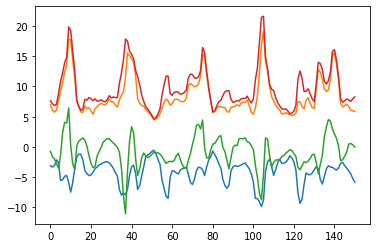

In [4]:
#simple plot of first entry
plt.plot(X[6000])
plt.show()

In [ ]:

# Drop component acceleration
log_xyz = "Using total component accel, deleting accel_x/y/z from X\n"
X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
log_file += log_xyz
#print(get_shapes([X,y,sub]))


In [5]:
# Drop either the three component accel or the total_accel
# TODO should name numpy columns and drop by name for versatility
# TODO this errors if run multiple times without reloading - part of name issue
# this assumes ['accel_x','accel_y','accel_z','total_accel']
use_xyz = False
if (use_xyz):
    log_xyz = "Using xyz component accel, deleting total_accel from X\n"
    X = np.delete(X, 3, 2) # delete column 4 along axis 2
else:
    log_xyz = "Using total component accel, deleting accel_x/y/z from X\n"
    X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
log_file += log_xyz
print(log_xyz)
print(get_shapes([X,y,sub]))


Using total component accel, deleting accel_x/y/z from X

X shape is (7579, 151, 1) data type is float64
y shape is (7579, 1) data type is uint8
sub shape is (7579, 1) data type is uint8



In [6]:

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping) # seems risky as interim step before one-hot
    log_file += "One Hot:" + str(name_mapping) +"\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n",get_shapes([X,y,sub]))

One-hot-encoding: category names -> int -> one-hot
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
One-hot-encoding [array([0, 1, 2, 3, 4, 5, 6, 7, 8])]

 X shape is (7579, 151, 1) data type is float64
y shape is (7579, 9) data type is float64
sub shape is (7579, 1) data type is uint8



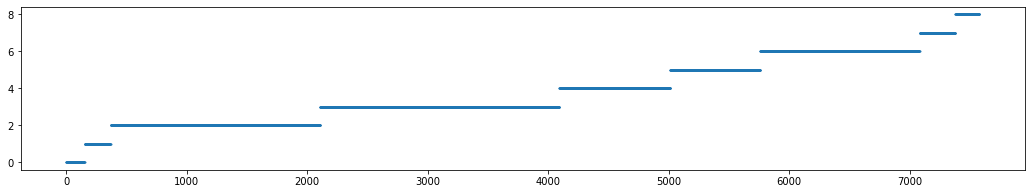

In [7]:
#show the classes by sample - data is ordered based on original directory
x_val = np.arange(y.shape[0]) #just a list of indices
plt.figure(figsize=(18, 3))
plt.scatter(x_val,y.argmax(axis=1),s=1)
plt.show()
#ACT = ['JOG','JUM','STD','STN','STU','WAL']

#This is the start of the train/test split code

Stratify using sklearn


In [8]:
#split into train/test using stratify
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
method = "sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)"
new_shapes = (get_shapes([X_train, X_test, y_train, y_test]))
log_file += "Split method " + method + "\n" + new_shapes + "\n"
print ("Split method " + method + "\n" + new_shapes + "\n")
#TODO - without indices cannot verify subject mix
#Add the subjects as a column in X and key off of that?
#https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices


Split method sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train shape is (6063, 151, 1) data type is float64
X_test shape is (1516, 151, 1) data type is float64
y_train shape is (6063, 9) data type is float64
y_test shape is (1516, 9) data type is float64




In [ ]:
#split by pre-selected subjects (original load data grouping)
method = "manual split using pre-selected subjects\n"
log_file = log_file + "Split: " + method
split_subj = {'train_subj':[4,5,6,7,8,10,11,12,14,15,19,20,21,22,24,26,27,29],
              'validation_subj':[1,9,16,23,25,28],
              'test_subj':[2,3,13,17,18,30]}
#split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
#                                36,38,42,45,46,47,48,49,50,51,52,53,54,57],
#                   'validation_subj':[3,6,8,11,12,22,37,40,43,56],
#                   'test_subj':[7,19,21,25,29,33,39,41,44,55]}

train_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['train_subj']:
    print(my_sub, end =" ")
    #print(np.argwhere(sub == my_sub)[:,0])
    train_index = np.concatenate((train_index, np.argwhere(sub == my_sub)[:,0]))

validation_index = np.empty([1],dtype=int) #empty list
print("\nValidation Group adding subjects:", end =" ")
for my_sub in split_subj['validation_subj']:
    print(my_sub, end =" ")
    validation_index = np.concatenate((validation_index, np.argwhere(sub == my_sub)[:,0]))

test_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['test_subj']:
    print(my_sub, end =" ")
    test_index = np.concatenate((test_index, np.argwhere(sub == my_sub)[:,0]))

print("\n")
#delete first row placeholders
train_index = np.delete(train_index, (0), axis=0) 
validation_index = np.delete(validation_index, (0), axis=0) 
test_index = np.delete(test_index, (0), axis=0)

X_train, X_test, X_validation = X[train_index], X[test_index], X[validation_index]
y_train, y_test, y_validation = y[train_index], y[test_index], y[validation_index]
new_shapes = get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test])
print (new_shapes)
log_file = log_file + new_shapes


Train Group adding subjects: 4 5 6 7 8 10 11 12 14 15 19 20 21 22 24 26 27 29 
Validation Group adding subjects: 1 9 16 23 25 28 
Train Group adding subjects: 2 3 13 17 18 30 

X_train shape is (4601, 151, 1) data type is float64
y_train shape is (4601, 9) data type is float64
X_validation shape is (1454, 151, 1) data type is float64
y_validation shape is (1454, 9) data type is float64
X_test shape is (1524, 151, 1) data type is float64
y_test shape is (1524, 9) data type is float64



In [ ]:
#split by subject using sklearn GroupKFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
method = "sklearn GroupKFold(n_splits=10)"
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(X, y, sub)
for train_index, test_index in group_kfold.split(X, y, sub):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
#Working code to show which subjects went to train, validation, and test
#Uses the index which in the case of GroupKFold is the last fold
#Does not work for stratify since there is no index generated
#TODO:  Output format especially for logging should be improved
#TODO:  Make list to handle 1 - 3 groups (original, train/test, +validate)
unique_elements, counts_elements = np.unique(sub[train_index], return_counts=True)
print("Train group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))
unique_elements, counts_elements = np.unique(sub[validation_index], return_counts=True)
print("Validation group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))
unique_elements, counts_elements = np.unique(sub[test_index], return_counts=True)
print("Test group sample count per subject:")
print(np.asarray((unique_elements, counts_elements)))

NameError: ignored

Separation Method: manual split using pre-selected subjects

x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)


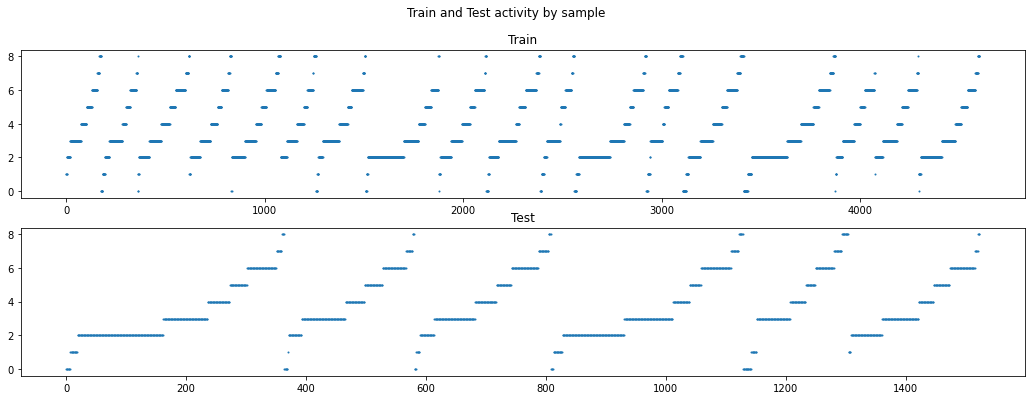

In [ ]:
print("Separation Method:",method)
print("x/y_train shape ",X_train.shape,y_train.shape)
print("x/y_test shape  ",X_test.shape,y_test.shape)
x_val = np.arange(y_train.shape[0]) #just a list of indices
fig, (ax1, ax2) = plt.subplots(2,figsize=(18, 6))
fig.suptitle('Train and Test activity by sample')
# x - list of indices using arange and num rows
# y - argmax to unwind one-hot encoding
# s = 1 sets dot size to smallest
ax1.set_title('Train')
ax1.scatter(np.arange(y_train.shape[0]), y_train.argmax(axis=1),s=1)
ax2.set_title('Test')
ax2.scatter(np.arange(y_test.shape[0]), y_test.argmax(axis=1),s=1)
plt.show()

In [10]:
#Don't need to rerun the above so log_file stays same after this cell
log_file = log_file + "Debugging UniMiB Data Explore"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 102, 50)           2550      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 50)            125050    
_________________________________________________________________
dropout (Dropout)            (None, 53, 50)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1300)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               130100    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9

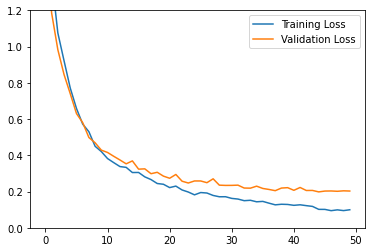

In [11]:
#Build/evaluate a simple model (also used in load_dataset_demo) topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
my_filters = 50
my_kernel_size = 50
BATCH_SIZE = 16
NUM_EPOCHS = 50
config_info = "filters = " + str(my_filters) + " kernel_size = "+ str(my_kernel_size)
config_info = config_info + " BATCH_SIZE = " + str(BATCH_SIZE) + " NUM_EPOCHS = " + str(NUM_EPOCHS)
if (True):
	n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
	model = keras.Sequential(
		[
			keras.Input(shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
			layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(100, activation='relu'),
			layers.Dense(n_outputs, activation='softmax')
   		]
	)
	model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()

history = model.fit(
        X_train,y_train,
        steps_per_epoch=X_train.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(X_test,y_test),
        validation_steps=X_test.shape[1]//BATCH_SIZE)

end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print(log_file)
print(config_info)
print('Training complete, processing time HH:MM:SS = ',train_time)
cpu_model = !grep 'model name' /proc/cpuinfo
print("CPU(s)", cpu_model)
gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
print("Using GPU",gpu_info[1])
print(method, "\nFinal Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0, 1.2])
plt.legend()
plt.show()